# Conditional Neural Processes (CNP) for 1D regression.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torchsnooper
import plotting_utils_cnp as plotting
import data_generator as data
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import dask.dataframe as dd
import sys
sys.path.append('../utilities')
import utilities as utils
import import_ipynb
import conditional_neural_process_model as cnp

importing Jupyter notebook from conditional_neural_process_model.ipynb


## Running Conditional Neural Processes

Now that we have defined the dataset as well as our model and its components we
can start building everything into the graph. Before we get started we need to
set some variables:

*   **`TRAINING_ITERATIONS`** - a scalar that describes the number of iterations
    for training. At each iteration we will sample a new batch of functions from
    the GP, pick some of the points on the curves as our context points **(x,
    y)<sub>C</sub>** and some points as our target points **(x,
    y)<sub>T</sub>**. We will predict the mean and variance at the target points
    given the context and use the log likelihood of the ground truth targets as
    our loss to update the model.
*   **`MAX_CONTEXT_POINTS`** - a scalar that sets the maximum number of contest
    points used during training. The number of context points will then be a
    value between 3 and `MAX_CONTEXT_POINTS` that is sampled at random for every
    iteration.
*   **`PLOT_AFTER`** - a scalar that regulates how often we plot the
    intermediate results.

In [2]:
TRAINING_ITERATIONS = int(3540) # Total number of training points: training_iterations * batch_size * max_content_points
#BATCH_SIZE = 100 # number of simulation configurations

MAX_CONTEXT_POINTS = 1000 # 2000 # 4000
MAX_TARGET_POINTS =  2000 # 4000 # 8000
CONTEXT_IS_SUBSET = True
BATCH_SIZE = 1
CONFIG_WISE = False
PLOT_AFTER = int(200)
torch.manual_seed(0)

# all available x config/ physics parameters are ["radius","thickness","npanels","theta","length","height","z_offset","volume","nC_Ge77","time_0[ms]","x_0[m]","y_0[m]","z_0[m]","px_0[m]","py_0[m]","pz_0[m]","ekin_0[eV]","edep_0[eV]","time_t[ms]","x_t[m]","y_t[m]","z_t[m]","px_t[m]","py_t[m]","pz_t[m]","ekin_t[eV]","edep_t[eV]","nsec"]
# Comment: if using data version v1.1 for training, "radius","thickness","npanels","theta","length" is probably necessary
names_x=["radius","thickness","npanels","theta","length","r_0[m]","z_0[m]","time_t[ms]","r_t[m]","z_t[m]","L_t[m]","ln(E0vsET)","edep_t[eV]","nsec"]
name_y ='total_nC_Ge77[cts]'
x_size = len(names_x)
if isinstance(name_y,str):
    y_size = 1
else:
    y_size = len(name_y)

RATIO_TESTING_VS_TRAINING = 1/40
version_cnp="v1.6"
version_lf="v1.4"
version_hf="v1.3"
path_to_files=f"../simulation/out/LF/{version_lf}/tier2/"
path_out = f'./out/'
f_out = f'{path_out}CNPGauss_{version_cnp}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}'

In [3]:
# Set data augmentation parameters
USE_DATA_AUGMENTATION = "mixup" #"smote" #False #"mixup"
USE_BETA = [0.1,0.1] # uniform => None, beta => [a,b] U-shape [0.1,0.1] Uniform [1.,1.] falling [0.2,0.5] rising [0.2,0.5]
SIGNAL_TO_BACKGROUND_RATIO = "" # "_1to4" # used for smote augmentation

if USE_DATA_AUGMENTATION:
    path_out = f'./out/{USE_DATA_AUGMENTATION}/'
    f_out = f'CNPGauss_{version_cnp}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}_{USE_DATA_AUGMENTATION}{SIGNAL_TO_BACKGROUND_RATIO}'
    if USE_DATA_AUGMENTATION == "mixup":
        path_to_files = f"../simulation/out/LF/{version_lf}/tier3/beta_{USE_BETA[0]}_{USE_BETA[1]}/"
        f_out = f'CNPGauss_{version_cnp}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}_beta_{USE_BETA[0]}_{USE_BETA[1]}'
    elif USE_DATA_AUGMENTATION == "smote" and CONFIG_WISE == True:
        path_to_files = f"../simulation/out/LF/{version_lf}/tier3/smote{SIGNAL_TO_BACKGROUND_RATIO}/"



In [4]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = cnp.DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'./out/{f_out}_model.pth'))
model.eval()


./out/CNPGauss_v1.9_4000_c1000_t2000_beta_0.1_0.1_model.pth


DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=15, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=46, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

0/303 2024-09-27 20:22:28, LF, radius: 208.7 cm, test loss: 37.02206802368164 (bce 0.2117694914340973)
1/303 2024-09-27 20:22:31, LF, radius: 194.6 cm, test loss: 58.087669372558594 (bce 0.3064119517803192)
2/303 2024-09-27 20:22:33, LF, radius: 240.3 cm, test loss: 81.0401382446289 (bce 0.4290315806865692)
3/303 2024-09-27 20:22:36, LF, radius: 215.3 cm, test loss: 361.6502990722656 (bce 1.141096591949463)
4/303 2024-09-27 20:22:38, LF, radius: 253.8 cm, test loss: 59.13003921508789 (bce 0.34325647354125977)
5/303 2024-09-27 20:22:40, LF, radius: 187.0 cm, test loss: 44.876976013183594 (bce 0.2362651526927948)
6/303 2024-09-27 20:22:42, LF, radius: 194.6 cm, test loss: 60.86112976074219 (bce 0.31151241064071655)
7/303 2024-09-27 20:22:44, LF, radius: 114.8 cm, test loss: 61.01150894165039 (bce 0.27598002552986145)
8/303 2024-09-27 20:22:46, LF, radius: 161.6 cm, test loss: 125.43603515625 (bce 0.5907607674598694)
9/303 2024-09-27 20:22:48, LF, radius: 174.8 cm, test loss: 82.538322448

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

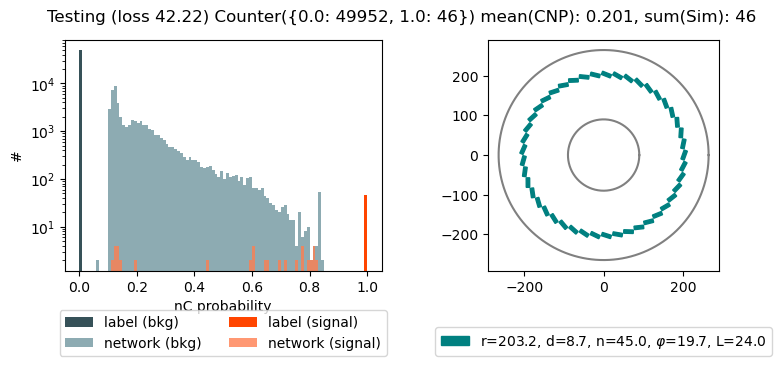

16/303 2024-09-27 20:23:04, LF, radius: 155.8 cm, test loss: 43.742828369140625 (bce 0.22051241993904114)
17/303 2024-09-27 20:23:07, LF, radius: 121.2 cm, test loss: 109.60916137695312 (bce 0.5061231851577759)
18/303 2024-09-27 20:31:00, LF, radius: 96.4 cm, test loss: 57.81593704223633 (bce 0.26497071981430054)
19/303 2024-09-27 20:31:03, LF, radius: 168.4 cm, test loss: 41.062435150146484 (bce 0.21151599287986755)
20/303 2024-09-27 20:31:05, LF, radius: 244.4 cm, test loss: 60.1919059753418 (bce 0.34735390543937683)
21/303 2024-09-27 20:31:08, LF, radius: 202.2 cm, test loss: 125.06095886230469 (bce 0.5635295510292053)
22/303 2024-09-27 20:31:11, LF, radius: 172.1 cm, test loss: 41.5343132019043 (bce 0.21513035893440247)
23/303 2024-09-27 20:31:13, LF, radius: 187.3 cm, test loss: 51.30723190307617 (bce 0.2711947560310364)
24/303 2024-09-27 20:31:15, LF, radius: 212.8 cm, test loss: 49.080162048339844 (bce 0.2737187147140503)
25/303 2024-09-27 20:31:19, LF, radius: 208.1 cm, test lo

/Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/conditional-neural-process/plotting_utils_cnp.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(9, 3))


36/303 2024-09-27 20:32:04, LF, radius: 161.4 cm, test loss: 72.65784454345703 (bce 0.37369757890701294)
37/303 2024-09-27 20:32:07, LF, radius: 222.3 cm, test loss: 93.51704406738281 (bce 0.4472604990005493)
38/303 2024-09-27 20:32:10, LF, radius: 111.9 cm, test loss: 70.90202331542969 (bce 0.3167535662651062)
39/303 2024-09-27 20:32:12, LF, radius: 137.4 cm, test loss: 48.588523864746094 (bce 0.2322506159543991)
40/303 2024-09-27 20:32:14, LF, radius: 182.0 cm, test loss: 38.185523986816406 (bce 0.20341897010803223)
41/303 2024-09-27 20:32:16, LF, radius: 118.9 cm, test loss: 70.3445053100586 (bce 0.31862589716911316)
42/303 2024-09-27 20:32:18, LF, radius: 242.6 cm, test loss: 54.73688888549805 (bce 0.3196321725845337)
43/303 2024-09-27 20:32:21, LF, radius: 191.0 cm, test loss: 38.471893310546875 (bce 0.19956427812576294)
44/303 2024-09-27 20:32:23, LF, radius: 250.7 cm, test loss: 107.77621459960938 (bce 0.5063934326171875)
45/303 2024-09-27 20:32:25, LF, radius: 201.3 cm, test lo

/Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/conditional-neural-process/../utilities/plotting_utils.py:372: RuntimeWarning: divide by zero encountered in scalar divide
  phi = 2.*np.pi/np.round(x[2])


300/303 2024-09-27 20:42:08, LF, radius: 95.0 cm, test loss: 86.28044891357422 (bce 0.43942803144454956)
301/303 2024-09-27 20:42:11, LF, radius: 200.0 cm, test loss: 117.15757751464844 (bce 0.5807053446769714)
302/303 2024-09-27 20:42:13, LF, radius: 116.02 cm, test loss: 54.97425842285156 (bce 0.2549245357513428)


/Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/conditional-neural-process/plotting_utils_cnp.py:132: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0].set_yscale("log")


<Figure size 640x480 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:

mode="LF"
filelist = utils.get_all_files(f"../simulation/out/{mode}/{version_lf}/tier2/neutron")
num_total_points = 50000


MAX_CONTEXT_POINTS_NEW = int(1/3 * num_total_points)
MAX_TARGET_POINTS_NEW = 2 * (MAX_CONTEXT_POINTS_NEW)
bce = nn.BCELoss()

x_lf = np.empty([0,6])
sum_target_y_lf = np.empty([0,1])
mean_mu_cnp_lf = np.empty([0,1])
mean_sigma_cnp_lf = np.empty([0,1])
rGe77_lf = np.empty([0,1])
totGe77_lf = np.empty([0,1])
totGe77_hf = np.empty([0,1])
hist_target_sig_lf = hist_target_bkg_lf = hist_pred_sig_lf = hist_pred_bkg_lf = np.zeros(100)
fout = open(f'{path_out}{f_out}_training.txt', "a")

# create a PdfPages object
pdf = PdfPages(f'{path_out}{f_out}_result_{mode}.pdf')

for i,file in enumerate(filelist):
    
    path_to_files = file[:-4]
    dataset_config = data.DataGeneration(num_iterations=1, num_context_points=MAX_CONTEXT_POINTS_NEW, num_target_points=MAX_TARGET_POINTS_NEW, batch_size = 1, use_data_augmentation="None", path_to_files=path_to_files,x_size=x_size,y_size=y_size, mode = "config", ratio_testing=0.,names_x=names_x, name_y=name_y)
    data_config = dataset_config.get_data(0, CONTEXT_IS_SUBSET)
    # Get the predicted mean and variance at the target points for the testing set
    log_prob_config, mu_config, sigma_config = model(data_config.query, data_config.target_y)
    # Define the loss
    config_loss = -log_prob_config.mean()
    if max(mu_config[0].detach().numpy()) <= 1 and min(mu_config[0].detach().numpy()) >= 0:
            loss_bce_config = bce(mu_config,  data_config.target_y)
    else:
            loss_bce_config = -1.

    mu_config = mu_config[0].detach().numpy()
    target_y = data_config.target_y[0].detach().numpy()
    df = pd.read_csv(file, index_col=0)
    tmp = df[["fidelity","radius","thickness","npanels","theta","length"]].to_numpy()
    x_lf         = np.append(x_lf,[df[["fidelity","radius","thickness","npanels","theta","length"]].to_numpy()[0]],axis=0)

    sum_target_y_tmp = np.array([np.sum(target_y)])
    sum_target_y_lf    = np.append(sum_target_y_lf, [sum_target_y_tmp], axis=0)
    mean_mu_tmp = np.array([np.mean(mu_config)])
    mean_mu_cnp_lf = np.append(mean_mu_cnp_lf, [mean_mu_tmp], axis=0)
    mean_sigma_tmp = np.array([np.mean(sigma_config[0].detach().numpy())])
    mean_sigma_cnp_lf = np.append(mean_sigma_cnp_lf, [mean_sigma_tmp], axis=0)
    rGe77_lf = np.append(rGe77_lf,[np.array([np.sum(pd.read_csv(file)["prod_rate_Ge77[nuc/(kg*yr)]"].to_numpy())])], axis=0)
    totGe77_lf = np.append(totGe77_lf,[np.array([np.sum(pd.read_csv(file)["total_nC_Ge77[cts]"].to_numpy())])], axis=0)

    hist_target_sig2, hist_target_bkg2, hist_pred_sig2, hist_pred_bkg2 = plotting.sum_hist(mu_config, target_y, hist_target_sig_lf, hist_target_bkg_lf, hist_pred_sig_lf, hist_pred_bkg_lf)

    print("{}/{} {}, {}, radius: {} cm, test loss: {} (bce {})".format(i,len(filelist),datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), mode,x_lf[-1,1], config_loss, loss_bce_config))
    fout.write("{}, Iteration: {}, test loss: {} (bce {})\n".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i, config_loss, loss_bce_config))
    fig = plotting.plot_result_configwise(mu_config, target_y, f'{config_loss:.2f}', x_lf[-1][1:])
    pdf.savefig(fig)

    if i==15:
        hist_target_sig2= hist_target_sig_lf
        hist_target_bkg2 = hist_target_bkg_lf
        hist_pred_sig2 = hist_pred_sig_lf
        hist_pred_bkg2 = hist_pred_bkg_lf
        plt.show()
    plt.clf()
    
fig1 = plotting.plot_result_summed(hist_target_sig_lf, hist_target_bkg_lf, hist_pred_sig_lf, hist_pred_bkg_lf)
pdf.savefig(fig1)
#plt.show()
plt.clf()
pdf.close()

fout.close()

df = pd.DataFrame(x_lf, columns=["Mode","Radius[cm]","Thickness[cm]","NPanels","Theta[deg]","Length[cm]"])
df['Ge-77[nevents]'] = sum_target_y_lf
df['Ge-77_CNP'] = mean_mu_cnp_lf
df['Ge-77_CNP_err'] = mean_sigma_cnp_lf
df['rGe77[nuc/(kg*yr)]'] = rGe77_lf
df=df.round(decimals=4)
df.to_csv(f'{path_out}{f_out}_Ge77rates.csv')




0/6 2024-09-27 20:42:22, HF, radius: 0.0 cm, test loss: 273.5470886230469 (bce 0.4602942168712616)


/Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/conditional-neural-process/../utilities/plotting_utils.py:372: RuntimeWarning: divide by zero encountered in scalar divide
  phi = 2.*np.pi/np.round(x[2])


1/6 2024-09-27 20:42:28, HF, radius: 95.0 cm, test loss: 135.0530548095703 (bce 0.24230749905109406)
2/6 2024-09-27 20:42:36, HF, radius: 200.0 cm, test loss: 140.9678192138672 (bce 0.30528953671455383)
3/6 2024-09-27 20:42:43, HF, radius: 116.2 cm, test loss: 179.11289978027344 (bce 0.21680448949337006)
4/6 2024-09-27 20:42:50, HF, radius: 134.1 cm, test loss: 118.81468200683594 (bce 0.17081105709075928)
5/6 2024-09-27 20:42:56, HF, radius: 176.6 cm, test loss: 120.26312255859375 (bce 0.15524673461914062)


<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

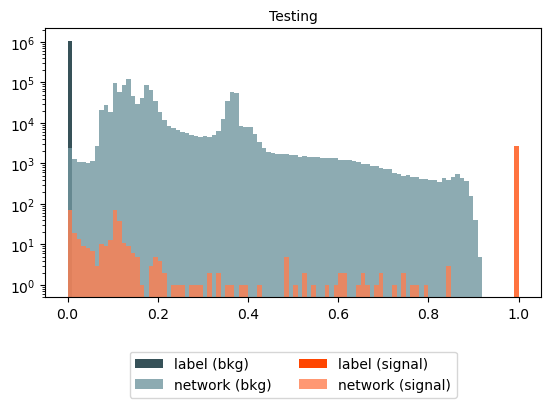

<Figure size 640x480 with 0 Axes>

In [6]:


mode="HF"

filelist = utils.get_all_files(f"../simulation/out/{mode}/{version_hf}/tier2/neutron")

x_hf = np.empty([0,6])
sum_target_y_hf = np.empty([0,1])
mean_mu_cnp_hf = np.empty([0,1])
mean_sigma_cnp_hf = np.empty([0,1])
upper_lim_hf = np.empty([0,1])
rGe77_hf = np.empty([0,1])
totGe77_hf = np.empty([0,1])
hist_target_sig_hf = hist_target_bkg_hf = hist_pred_sig_hf = hist_pred_bkg_hf = np.zeros(100)
fout = open(f'{path_out}{f_out}_training.txt', "a")

# create a PdfPages object
pdf=PdfPages(f'{path_out}{f_out}_result_{mode}.pdf')

for i,file in enumerate(filelist):

    path_to_files = file[:-4]
    num_total_points = 0
    with open(file, "rbU") as f:
        num_total_points += int(np.floor(sum(1 for _ in f)))

    MAX_CONTEXT_POINTS_NEW = int(1/3 * (num_total_points-1))
    MAX_TARGET_POINTS_NEW = 2 * MAX_CONTEXT_POINTS_NEW

    dataset_config = data.DataGeneration(num_iterations=1, num_context_points=MAX_CONTEXT_POINTS_NEW, num_target_points=MAX_TARGET_POINTS_NEW, batch_size = 1, use_data_augmentation="None", path_to_files=path_to_files,x_size=x_size,y_size=y_size, mode = "config", ratio_testing=0.,names_x=names_x, name_y=name_y)
    data_config = dataset_config.get_data(0, CONTEXT_IS_SUBSET)
    
    # Get the predicted mean and variance at the target points for the testing set
    log_prob_config, mu_config, sigma_config = model(data_config.query, data_config.target_y)
    # Define the loss
    config_loss = -log_prob_config.mean()
    if max(mu_config[0].detach().numpy()) <= 1 and min(mu_config[0].detach().numpy()) >= 0:
            loss_bce_config = bce(mu_config,  data_config.target_y)
    else:
            loss_bce_config = -1.

    mu_config = mu_config[0].detach().numpy()
    
    target_y = data_config.target_y[0].detach().numpy()
    df = pd.read_csv(file, index_col=0)
    x_hf         = np.append(x_hf,[df[["fidelity","radius","thickness","npanels","theta","length"]].to_numpy()[0]],axis=0)
    #x         = np.append(x,[data_config.query[1][0][0][-5:].numpy()],axis=0)
    sum_target_y_tmp = np.array([np.sum(target_y)])
    sum_target_y_hf    = np.append(sum_target_y_hf, [sum_target_y_tmp], axis=0)
    mean_mu_tmp = np.array([np.mean(mu_config)])
    upper_lim_hf = np.append(upper_lim_hf,[np.array([np.percentile(mu_config,95.)])], axis=0)
    mean_mu_cnp_hf = np.append(mean_mu_cnp_hf, [mean_mu_tmp], axis=0)
    mean_sigma_tmp = np.array([np.mean(sigma_config[0].detach().numpy())])
    mean_sigma_cnp_hf = np.append(mean_sigma_cnp_hf, [mean_sigma_tmp], axis=0)
    rGe77_hf = np.append(rGe77_hf,[np.array([np.sum(pd.read_csv(file)["prod_rate_Ge77[nuc/(kg*yr)]"].to_numpy())])], axis=0)
    totGe77_hf = np.append(totGe77_hf,[np.array([np.sum(pd.read_csv(file)["total_nC_Ge77[cts]"].to_numpy())])], axis=0)

    hist_target_sig_hf, hist_target_bkg_hf, hist_pred_sig_hf, hist_pred_bkg_hf = plotting.sum_hist(mu_config, target_y, hist_target_sig_hf, hist_target_bkg_hf, hist_pred_sig_hf, hist_pred_bkg_hf)
    print("{}/{} {}, {}, radius: {} cm, test loss: {} (bce {})".format(i,len(filelist),datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), mode,x_hf[-1,1], config_loss, loss_bce_config))
    fout.write("{}, Iteration: {}, test loss: {} (bce {})\n".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i, config_loss, loss_bce_config))
   
    fig = plotting.plot_result_configwise(mu_config, target_y, f'{config_loss:.2f}', x_hf[-1][1:])
    pdf.savefig(fig)
    #plt.show()
    plt.clf()

    
fig1 = plotting.plot_result_summed(hist_target_sig_hf, hist_target_bkg_hf, hist_pred_sig_hf, hist_pred_bkg_hf)
pdf.savefig(fig1)
plt.show()
plt.clf()
pdf.close()

fout.close()

df= pd.read_csv(f'{path_out}{f_out}_Ge77rates.csv', index_col=0)
x = df[["Mode","Radius[cm]","Thickness[cm]","NPanels","Theta[deg]","Length[cm]","Ge-77[nevents]","Ge-77_CNP","Ge-77_CNP_err","rGe77[nuc/(kg*yr)]"]].to_numpy()
x_tmp = np.append(x_hf, sum_target_y_hf, axis=1)
x_tmp = np.append(x_tmp, mean_mu_cnp_hf, axis=1)
x_tmp = np.append(x_tmp, mean_sigma_cnp_hf, axis=1)
x_tmp = np.append(x_tmp, rGe77_hf, axis=1)
x = np.append(x, x_tmp, axis=0)
df = pd.DataFrame(x, columns=df.columns)

df=df.round(decimals=4)
df.to_csv(f'{path_out}{f_out}_Ge77rates.csv')
df.to_csv(f'../multi-fidelity-gaussian-process/in/Ge77_rates_CNP_{version_cnp}.csv')


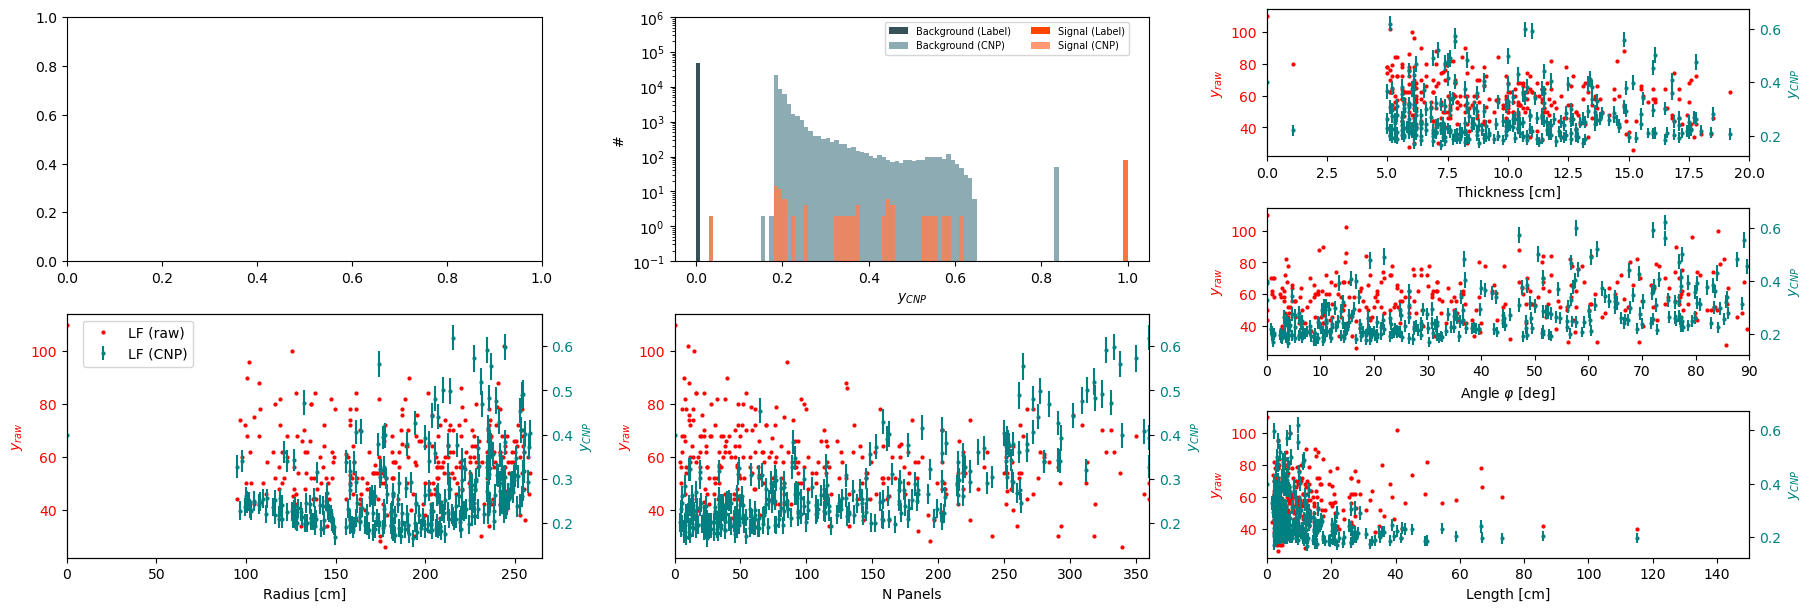

In [8]:
color_sim_hf="black"
color_cnp_hf="black"
color_sim_lf="red"
color_cnp_lf="teal"

xmin=[0,0,0,0,0]
xmax=[265,20,360,90,150]
indices = [0,2,1,3,4]
xlabels=["Radius [cm]","Thickness [cm]","N Panels",r"Angle $\varphi$ [deg]","Length [cm]"]

fig = plt.figure(figsize=(18,6), layout = "constrained")
gs0=fig.add_gridspec(1,2, width_ratios = [2,1])

gs00 = gs0[0].subgridspec(2,2)
gs01 = gs0[1].subgridspec(3,1)
for l in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs00[l,j])
        if l == 0 and j==1:
            nbins = len(hist_target_sig2)
            range2 = [0.0, 1.0]
            bin_length = (range2[1]-range2[0])/nbins
            bins = np.arange(range2[0],range2[1]+bin_length, bin_length)
            centroids = (bins[1:] + bins[:-1]) / 2

            ax.hist(centroids, weights = hist_target_bkg2, range=range2, bins=nbins, color=(3/255,37/255,46/255), alpha=0.8, label='Background (Label)')
            ax.hist(centroids, weights = hist_pred_bkg2, range=range2, bins=nbins, color=(113/255,150/255,159/255), alpha=0.8, label='Background (CNP)')
            ax.hist(centroids, weights = hist_target_sig2, range=range2, bins=nbins, color='orangered', alpha=1.0, label='Signal (Label)')
            ax.hist(centroids, weights = hist_pred_sig2, range=range2, bins=nbins, color='coral', alpha=0.8, label='Signal (CNP)')
            ax.set_xlabel(r"$y_{CNP}$", fontsize=10)
            ax.set_ylabel(r'#', fontsize=10)
            ax.set_yscale("log")
            ax.set_ylim(0.1,1000000)
            ax.legend(loc=9, bbox_to_anchor=(0.7,1.), ncol=2,fontsize=7)

        if l == 1:
            i=j
            plt.plot(x_lf[:,indices[i]+1],totGe77_lf,"o",markersize=2, color=color_sim_lf, label="LF (raw)")
            #plt.plot(x_hf[:,indices[i]+1],totGe77_hf,">",markersize=4, color=color_sim_hf, label="HF (raw)")
            ax.set_xlim(xmin[indices[i]],xmax[indices[i]])#
            ax.set_xlabel(xlabels[indices[i]], fontsize=10)
            ax.set_ylabel(r'$y_{raw}$',color=color_sim_lf, fontsize=10)
            plt.tick_params(axis='y', labelcolor=color_sim_lf)
            handles = plt.gca().get_legend_handles_labels()[0]
            labels = plt.gca().get_legend_handles_labels()[1]

            ax = plt.twinx()
            plt.errorbar(x_lf[:,indices[i]+1], mean_mu_cnp_lf[:,0], yerr=mean_sigma_cnp_lf[:,0],fmt='o',markersize=2, color=color_cnp_lf, label="LF (CNP)")
            #plt.errorbar(x_hf[:,indices[i]+1], mean_mu_cnp_hf[:,0], yerr=mean_sigma_cnp_hf[:,0],fmt='s',markersize=4, color=color_cnp_hf, label="HF (CNP)")
            plt.tick_params(axis='y', labelcolor=color_cnp_lf)

            for t in range(len(plt.gca().get_legend_handles_labels()[1])):
                handles.append(plt.gca().get_legend_handles_labels()[0][t])
                labels.append(plt.gca().get_legend_handles_labels()[1][t])

            ax.set_ylabel(r'$y_{CNP}$',color=color_cnp_lf, fontsize=10)
            if j==0:
                plt.legend(handles,labels,loc=9, bbox_to_anchor=(0.15,1.),ncol=1)

for j in range(3):
    ax = fig.add_subplot(gs01[j])
    i=j+2
    plt.plot(x_lf[:,indices[i]+1],totGe77_lf,'o',markersize=2, color=color_sim_lf, label="LF (raw)")
    #plt.plot(x_hf[:,indices[i]+1],totGe77_hf,'s',markersize=4, color=color_sim_hf, label="HF (raw)")
    ax.set_xlim(xmin[indices[i]],xmax[indices[i]])#
    ax.set_xlabel(xlabels[indices[i]], fontsize=10)
    ax.set_ylabel(r'$y_{raw}$',color=color_sim_lf, fontsize=10)
    
    plt.tick_params(axis='y', labelcolor=color_sim_lf)
    
    ax = plt.twinx()
    plt.errorbar(x_lf[:,indices[i]+1], mean_mu_cnp_lf[:,0], yerr=mean_sigma_cnp_lf[:,0],fmt='o',markersize=2, color=color_cnp_lf, label="LF (CNP)")
    #plt.errorbar(x_hf[:,indices[i]+1], mean_mu_cnp_hf[:,0], yerr=mean_sigma_cnp_hf[:,0],fmt='>',markersize=4, color=color_cnp_hf, label="HF (CNP)")
    plt.tick_params(axis='y', labelcolor=color_cnp_lf)
    ax.set_ylabel(r'$y_{CNP}$',color=color_cnp_lf, fontsize=10)
fig.savefig(f"testing_before_after_cnp_{version_cnp}.png")
